In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from PIL import Image
import io


In [2]:
# Load the training and test datasets
train_df = pd.read_parquet(r'C:\Users\aarek\etsydata\train')
test_df = pd.read_parquet(r'C:\Users\aarek\etsydata\test')


# Exploratory Data Analysis (EDA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229624 entries, 0 to 229623
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   product_id            229624 non-null  int64 
 1   title                 229624 non-null  object
 2   description           229624 non-null  object
 3   tags                  229624 non-null  object
 4   type                  229624 non-null  object
 5   room                  229624 non-null  object
 6   craft_type            229624 non-null  object
 7   recipient             229624 non-null  object
 8   material              229624 non-null  object
 9   occasion              229624 non-null  object
 10  holiday               229624 non-null  object
 11  art_subject           229624 non-null  object
 12  style                 229624 non-null  object
 13  shape                 229624 non-null  object
 14  pattern               229624 non-null  object
 15  bottom_category_i

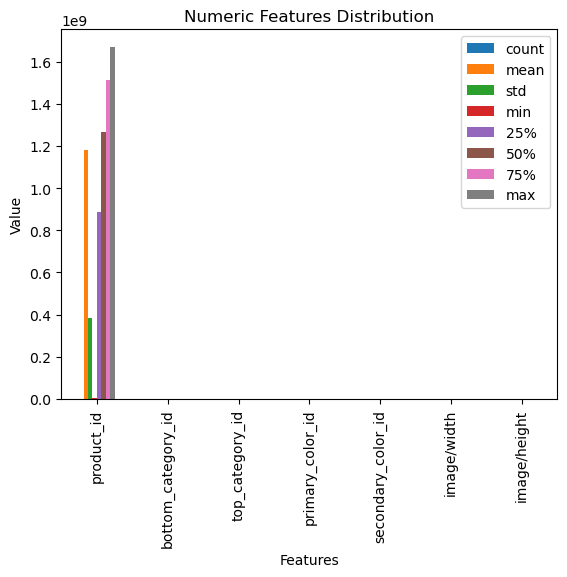

In [3]:
# Display basic information
print(train_df.info())

# Plot distributions of numeric features
train_df.describe().transpose().plot(kind='bar')
plt.title('Numeric Features Distribution')
plt.ylabel('Value')
plt.xlabel('Features')
plt.show()  # Display the plot and start a new figure


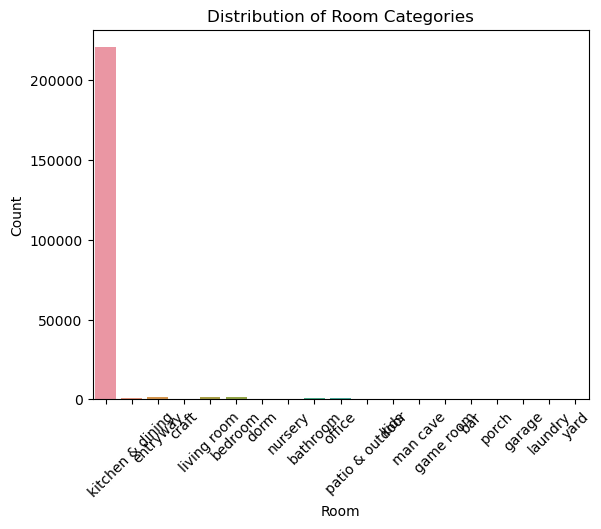

In [4]:
# Plot some categorical data
sns.countplot(data=train_df, x='room')
plt.title('Distribution of Room Categories')
plt.ylabel('Count')
plt.xlabel('Room')
plt.xticks(rotation=45)  # Rotate x labels for better readability if needed
plt.show()  # Display the plot and start a new figure

C:\Users\aarek\AppData\Local\Temp\ipykernel_17908\3098754922.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')


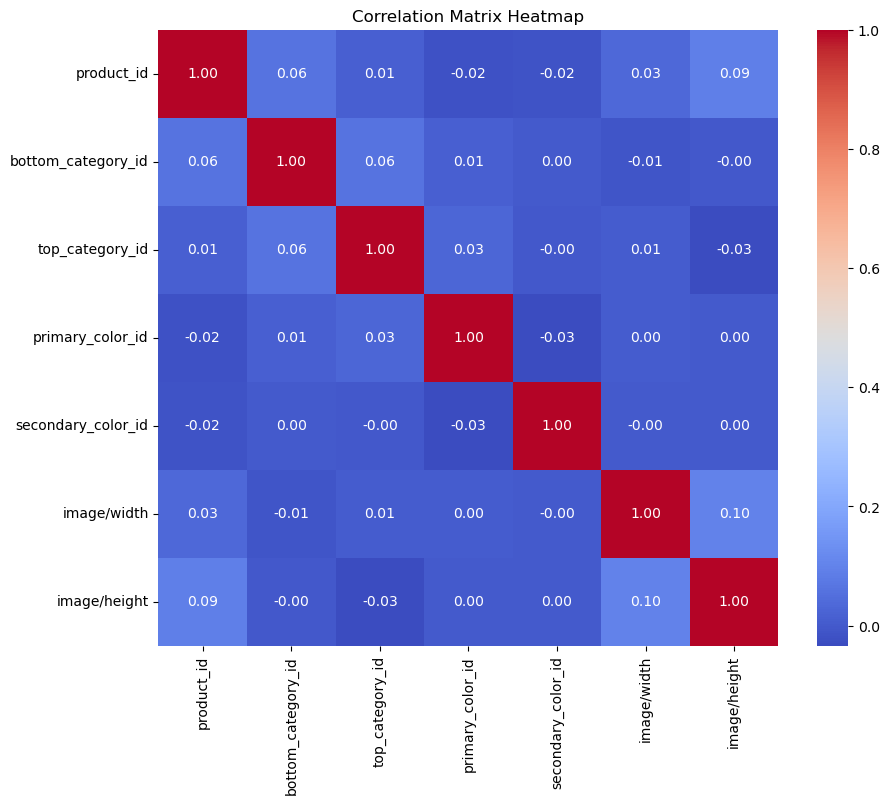

In [5]:
# Correlation matrix heatmap
plt.figure(figsize=(10, 8))  # Set a figure size for better readability
sns.heatmap(train_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()  # Display the plot and start a new figure

In [6]:
# Check for null values in the training data
print(train_df.isnull().sum())

# Check for null values in the test data
print(test_df.isnull().sum())

product_id              0
title                   0
description             0
tags                    0
type                    0
room                    0
craft_type              0
recipient               0
material                0
occasion                0
holiday                 0
art_subject             0
style                   0
shape                   0
pattern                 0
bottom_category_id      0
bottom_category_text    0
top_category_id         0
top_category_text       0
primary_color_id        0
primary_color_text      0
secondary_color_id      0
secondary_color_text    0
image/encoded           0
image/width             0
image/height            0
dtype: int64
product_id       0
title            0
description      0
tags             0
type             0
room             0
craft_type       0
recipient        0
material         0
occasion         0
holiday          0
art_subject      0
style            0
shape            0
pattern          0
image/encoded    0
image/w

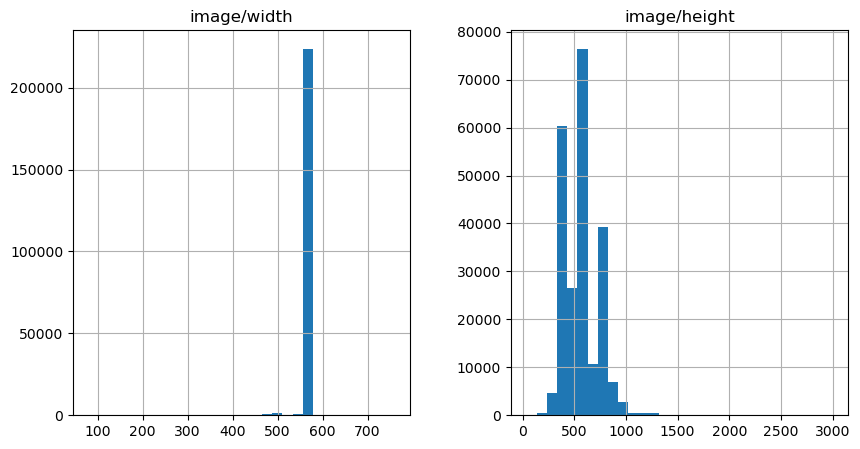

In [7]:
train_df[['image/width', 'image/height']].hist(bins=30, figsize=(10, 5))
plt.show()


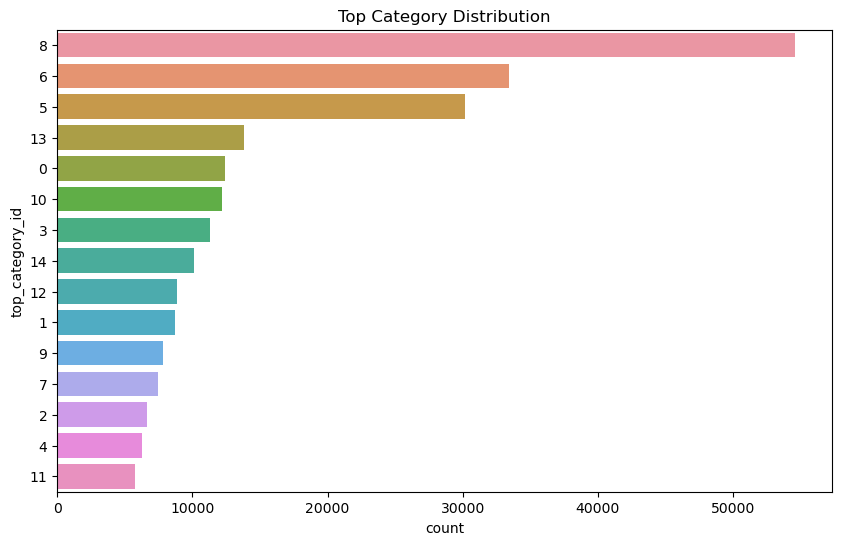

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(y='top_category_id', data=train_df, order = train_df['top_category_id'].value_counts().index)
plt.title('Top Category Distribution')
plt.show()


# Preprocess Data

Preprocessing the dataset (encoding, scaling, image preprocessing):

In [9]:
# Reduce Image Size

# Convert Images to a Lower Precision Data Type

# The numpy arrays are using the default float64 data type, which is quite memory-intensive. 
# we can reduce the memory usage by converting the images to a lower precision data type, such as float32.

def preprocess_image(image_bytes):
    img = Image.open(io.BytesIO(image_bytes)).resize((128, 128))
    img_array = np.array(img, dtype=np.float32) / 255.0  # Convert to float32
    return img_array


In [10]:
import os

def save_processed_images(df, directory='processed_images'):
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    for idx, row in df.iterrows():
        img_array = preprocess_image(row['image/encoded'])
        filepath = os.path.join(directory, f'image_{idx}.npy')
        np.save(filepath, img_array)

save_processed_images(train_df)

# Then, create a generator to load these images in batches for training
def batch_image_generator(filepaths, batch_size):
    while True:  # Loop indefinitely
        for i in range(0, len(filepaths), batch_size):
            batch_paths = filepaths[i:i+batch_size]
            images = [np.load(path) for path in batch_paths]
            yield np.array(images)

# Example filepaths list generation
filepaths = [os.path.join('processed_images', f'image_{idx}.npy') for idx in range(len(train_df))]


In [11]:
# Use Generators for Large Datasets

# If the dataset is very large, consider using a generator that yields processed images on-the-fly instead
# of storing them all in memory at once. This approach is particularly useful when training models with Keras, 
# as we can use the fit_generator method

def image_generator(df, batch_size=32):
    num_images = len(df)
    while True:  # Loop indefinitely
        for start in range(0, num_images, batch_size):
            end = min(start + batch_size, num_images)
            batch = df[start:end]
            images = np.stack(batch['image/encoded'].apply(preprocess_image))
            # Yield the batch of images
            yield images

# Example usage with a model.fit_generator in place of model.fit


# Prpare Model

In [18]:
# Print the column names of the DataFrame
print(train_df.columns)


Index(['product_id', 'title', 'description', 'tags', 'type', 'room',
       'craft_type', 'recipient', 'material', 'occasion', 'holiday',
       'art_subject', 'style', 'shape', 'pattern', 'bottom_category_id',
       'bottom_category_text', 'top_category_id', 'top_category_text',
       'primary_color_id', 'primary_color_text', 'secondary_color_id',
       'secondary_color_text', 'image/encoded', 'image/width', 'image/height'],
      dtype='object')


In [19]:
# Assuming you have loaded your dataset into a DataFrame called `train_df`
num_top_categories = train_df['top_category_text'].nunique()
num_bottom_categories = train_df['bottom_category_text'].nunique()
num_primary_colors = train_df['primary_color_text'].nunique()
num_secondary_colors = train_df['secondary_color_text'].nunique()


In [20]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Helps reduce overfitting

# Define multiple outputs using the corrected number of unique classes
top_category = Dense(num_top_categories, activation='softmax', name='top_category')(x)
bottom_category = Dense(num_bottom_categories, activation='softmax', name='bottom_category')(x)
primary_color = Dense(num_primary_colors, activation='softmax', name='primary_color')(x)
secondary_color = Dense(num_secondary_colors, activation='softmax', name='secondary_color')(x)

# Final model setup
model = Model(inputs=base_model.input, outputs=[top_category, bottom_category, primary_color, secondary_color])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 230, 230, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 56, 56, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 56, 56, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 56, 56, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 28,414,438 (108.39 MB)

 Trainable params: 28,361,318 (108.19 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [21]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Example for one-hot encoding the 'top_category_text'
label_encoder = LabelEncoder()
top_category_labels = label_encoder.fit_transform(train_df['top_category_text'])
top_category_labels = to_categorical(top_category_labels)


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setup data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize images
    rotation_range=20,  # Random rotation between 0 and 20 degrees
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    shear_range=0.1,  # Shearing
    zoom_range=0.1,  # Zooming
    horizontal_flip=True,  # Horizontal flipping
    fill_mode='nearest'
)

# Apply similar normalization for validation data but without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)


In [26]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Create label encoders for each categorical attribute
le_top = LabelEncoder()
le_bottom = LabelEncoder()
le_primary = LabelEncoder()
le_secondary = LabelEncoder()

# Fit and transform the labels to label encodings
top_category_labels = le_top.fit_transform(train_df['top_category_text'])
bottom_category_labels = le_bottom.fit_transform(train_df['bottom_category_text'])
primary_color_labels = le_primary.fit_transform(train_df['primary_color_text'])
secondary_color_labels = le_secondary.fit_transform(train_df['secondary_color_text'])

# Convert to one-hot encodings
top_category_encoded = to_categorical(top_category_labels)
bottom_category_encoded = to_categorical(bottom_category_labels)
primary_color_encoded = to_categorical(primary_color_labels)
secondary_color_encoded = to_categorical(secondary_color_labels)


In [25]:
# # Define a custom generator if needed to handle multiple outputs
# def my_generator(df, batch_size=32):
#     while True:
#         for start in range(0, len(df), batch_size):
#             x_batch = []
#             y_batch_top = []
#             y_batch_bottom = []
#             y_batch_primary = []
#             y_batch_secondary = []
#             end = min(start + batch_size, len(df))
#             sub_df = df.iloc[start:end]
#             for _, row in sub_df.iterrows():
#                 img = load_and_preprocess_image(row['image_path'])  # Define this function as needed
#                 x_batch.append(img)
#                 y_batch_top.append(row['top_category_encoded'])
#                 y_batch_bottom.append(row['bottom_category_encoded'])
#                 y_batch_primary.append(row['primary_color_encoded'])
#                 y_batch_secondary.append(row['secondary_color_encoded'])
#             yield np.array(x_batch), [np.array(y_batch_top), np.array(y_batch_bottom), np.array(y_batch_primary), np.array(y_batch_secondary)]


In [27]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Create label encoders for each categorical attribute
le_top = LabelEncoder()
le_bottom = LabelEncoder()
le_primary = LabelEncoder()
le_secondary = LabelEncoder()

# Fit and transform the labels to label encodings
top_category_labels = le_top.fit_transform(train_df['top_category_text'])
bottom_category_labels = le_bottom.fit_transform(train_df['bottom_category_text'])
primary_color_labels = le_primary.fit_transform(train_df['primary_color_text'])
secondary_color_labels = le_secondary.fit_transform(train_df['secondary_color_text'])

# Convert to one-hot encodings
top_category_encoded = to_categorical(top_category_labels)
bottom_category_encoded = to_categorical(bottom_category_labels)
primary_color_encoded = to_categorical(primary_color_labels)
secondary_color_encoded = to_categorical(secondary_color_labels)


In [31]:
# Print out some example encoded strings from the DataFrame
for encoded in train_df['image/encoded'].head(10):
    if encoded is not None:
        print(f"Length: {len(encoded)}, Mod 4: {len(encoded) % 4}, Data: {encoded[:50]}...")


Length: 47491, Mod 4: 3, Data: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f'...
Length: 37636, Mod 4: 0, Data: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f'...
Length: 70055, Mod 4: 3, Data: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f'...
Length: 25005, Mod 4: 1, Data: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f'...
Length: 93127, Mod 4: 3, Data: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x

In [ ]:
from PIL import Image
import io
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input

def load_and_preprocess_image(raw_image_data):
    try:
        # Open the image directly from bytes data
        img = Image.open(io.BytesIO(raw_image_data))
        img = img.convert('RGB')  # Ensure image is in RGB format
        img = img.resize((224, 224))  # Resizing to match the input size expected by ResNet50
        img = img_to_array(img)  # Convert the image to a numpy array
        img = preprocess_input(img)  # Apply ResNet50 preprocessing
        return img
    except Exception as e:
        print("Failed to process image:", e)
        return None

# Apply preprocessing to the raw image data in your DataFrame
image_data = [load_and_preprocess_image(encoded) for encoded in train_df['image/encoded'] if encoded is not None]
image_data = np.array([img for img in image_data if img is not None])


# Setting Up Our Data and Labels
 #Since our generator is set up to yield batches of images, we need to ensure that we also provide the 
#corresponding labels in a format that matches these batches. If our labels are categorical, we might need 
#to one-hot encode them, and then adjust the generator to yield a tuple (batch_images, batch_labels) on each iteration.

In [14]:
def image_label_generator(df, labels, batch_size=32):
    num_images = len(df)
    while True:  # Loop indefinitely
        for start in range(0, num_images, batch_size):
            end = min(start + batch_size, num_images)
            batch = df[start:end]
            images = np.stack(batch['image/encoded'].apply(preprocess_image))
            batch_labels = labels[start:end]  # Assuming `labels` is a NumPy array or similar
            yield images, batch_labels


# Training the Model

In [15]:
print(train_df.columns)



Index(['product_id', 'title', 'description', 'tags', 'type', 'room',
       'craft_type', 'recipient', 'material', 'occasion', 'holiday',
       'art_subject', 'style', 'shape', 'pattern', 'bottom_category_id',
       'bottom_category_text', 'top_category_id', 'top_category_text',
       'primary_color_id', 'primary_color_text', 'secondary_color_id',
       'secondary_color_text', 'image/encoded', 'image/width', 'image/height'],
      dtype='object')


In [16]:
from sklearn.model_selection import train_test_split

# Assuming you're predicting these four attributes and have extracted them as labels
labels = train_df[['bottom_category_id', 'top_category_id', 'primary_color_id', 'secondary_color_id']].values

# Split the data into training and validation sets (80% train, 20% validation)
train_df, validation_df, train_labels, validation_labels = train_test_split(
    train_df, 
    labels, 
    test_size=0.2, 
    random_state=42
)

# Now, your train_df and validation_df contain the split DataFrame, and
# train_labels and validation_labels contain the corresponding labels.


In [17]:
def image_label_generator(df, labels, batch_size=32):
    num_images = len(df)
    while True:  # Loop indefinitely
        for start in range(0, num_images, batch_size):
            end = min(start + batch_size, num_images)
            batch = df.iloc[start:end]
            images = np.stack(batch['image/encoded'].apply(preprocess_image))
            batch_labels = labels[start:end]
            yield images, batch_labels


In [23]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
batch_size = 32

# Prepare the generators
train_generator = image_label_generator(train_df, train_labels, batch_size=batch_size)
validation_generator = image_label_generator(validation_df, validation_labels, batch_size=batch_size)

steps_per_epoch = len(train_df) // batch_size
validation_steps = len(validation_df) // batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps
)


Epoch 1/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 1513s 263ms/step - accuracy: 0.0000e+00 - loss: 25365990538513219584.0000 - val_accuracy: 0.0000e+00 - val_loss: 25922176296400453632.0000
Epoch 2/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 1493s 260ms/step - accuracy: 0.0000e+00 - loss: 26225159919573663744.0000 - val_accuracy: 0.0000e+00 - val_loss: 26843747360383696896.0000
Epoch 3/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 1479s 258ms/step - accuracy: 0.0000e+00 - loss: 27163195070671224832.0000 - val_accuracy: 0.0000e+00 - val_loss: 27792014566689341440.0000
Epoch 4/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 1482s 258ms/step - accuracy: 0.0000e+00 - loss: 28147345938460966912.0000 - val_accuracy: 0.0000e+00 - val_loss: 28760266496341442560.0000
Epoch 5/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 1487s 259ms/step - accuracy: 0.0000e+00 - loss: 29111611038950752256.0000 - val_accuracy: 0.0000e+00 - val_loss: 29756839646501797888.0000
Epoch 6/10
5740/5740 ━━━━━━━━━━━━━━━━━━━━ 1503s 262ms/step - accuracy: 0.0000e+00 - loss: 30096

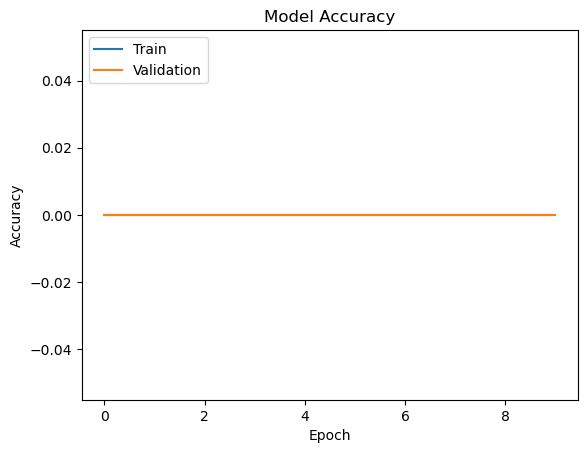

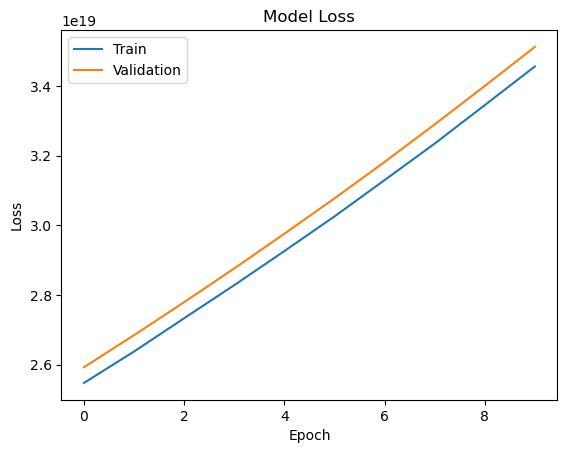

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [26]:
# Assuming `test_df` has been preprocessed similar to `train_df`
test_images = np.stack(test_df['image/encoded'].apply(preprocess_image))
predictions = model.predict(test_images)

# Process the predictions to interpret the model's outputs
# For example, if you have a classification task:
predicted_classes = np.argmax(predictions, axis=1)


798/798 ━━━━━━━━━━━━━━━━━━━━ 17s 20ms/step
